<a href="https://colab.research.google.com/github/larasauser/master/blob/main/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Baseline method

In [ ]:
!pip install rasterio

In [ ]:
import os
import re
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
from datetime import datetime

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
path_with_holes = "/content/drive/MyDrive/NDVI_grancy_Landsat8_10/imputed/holes_real"
path_full = "/content/drive/MyDrive/NDVI_grancy_Landsat8_10/imputed"
path_out = "/content/drive/MyDrive/NDVI_grancy_Landsat8_10/imputed/holes_real/filled_baseline"
os.makedirs(path_out, exist_ok=True)

In [ ]:
def extract_date(filename):
    match = re.search(r"(\d{4}-\d{2}-\d{2})", filename)
    if match:
        return datetime.strptime(match.group(1), "%Y-%m-%d")
    else:
        raise ValueError(f"Impossible to extract : {filename}")

In [ ]:
files_with_holes = sorted([f for f in os.listdir(path_with_holes) if f.endswith(".tif")])
files_full = sorted([f for f in os.listdir(path_full) if f.endswith(".tif")])
dates_full = {f: extract_date(f) for f in files_full}

In [ ]:
def find_closest_image(target_date, exclude_date):
    candidates = [(f, d) for f, d in dates_full.items() if d != exclude_date]
    closest = min(candidates, key=lambda x: abs(x[1] - target_date))
    return closest[0]

In [ ]:
# Reconstruction
for f in files_with_holes:
    date_f = extract_date(f)

    # Find closest image in time
    closest_file = find_closest_image(date_f, date_f)

    # Load image with hole
    with rasterio.open(os.path.join(path_with_holes, f)) as src_hole:
        img_hole = src_hole.read(1).astype("float32")
        profile = src_hole.profile
        target_transform = src_hole.transform
        target_crs = src_hole.crs
        target_shape = src_hole.shape

    # Load image full
    with rasterio.open(os.path.join(path_full, closest_file)) as src_full:
        cand_img = src_full.read(1).astype("float32")
        cand_transform = src_full.transform
        cand_crs = src_full.crs

    # Reprojection + recadrage pour matcher l'image trouée
    recropped = np.empty(target_shape, dtype="float32")
    reproject(
        source=cand_img,
        destination=recropped,
        src_transform=cand_transform,
        src_crs=cand_crs,
        dst_transform=target_transform,
        dst_crs=target_crs,
        resampling=Resampling.bilinear
    )

    # Construire masque des trous : NaN ou -9999
    mask = np.isnan(img_hole) | (img_hole == -9999)

    # Remplir les trous avec l'image reprojetée
    img_out = img_hole.copy()
    img_out[mask] = recropped[mask]

    # Préparer profil de sortie
    profile.update(dtype="float32", nodata=-9999)

    # Remplacer NaN par -9999 pour cohérence
    img_out[np.isnan(img_out)] = -9999

    # Sauvegarde
    out_path = os.path.join(path_out, f.replace(".tif", "_baseline.tif"))
    with rasterio.open(out_path, "w", **profile) as dst:
        dst.write(img_out, 1)

    print(f"{f} rempli avec {closest_file} → {out_path}")

Visualisation + error calculation

In [ ]:
!pip install rasterio

In [31]:
import os
import re
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [27]:
path_with_holes = "/content/drive/MyDrive/NDVI_grancy_Landsat8_10/imputed/holes_real"
path_full = "/content/drive/MyDrive/NDVI_grancy_Landsat8_10/imputed"
path_baseline = "/content/drive/MyDrive/NDVI_grancy_Landsat8_10/imputed/holes_real/filled_baseline"

In [23]:
# Utils
def extract_date(filename):
    match = re.search(r"(\d{4}-\d{2}-\d{2})", filename)
    if match:
        return datetime.strptime(match.group(1), "%Y-%m-%d")
    else:
        return None

files_full = sorted([f for f in os.listdir(path_full) if f.endswith(".tif")])
dates_full = {f: extract_date(f) for f in files_full}

def find_closest_ref(date, exclude_file):
    exclude_date = extract_date(exclude_file)
    diffs = [(abs((d - exclude_date).days), f) for f, d in dates_full.items() if d != exclude_date]
    return min(diffs, key=lambda x: x[0])[1]

mapping_dict = {}
files_with_holes = sorted([f for f in os.listdir(path_with_holes) if f.endswith(".tif")])
for f in files_with_holes:
    date = extract_date(f).strftime("%Y-%m-%d")
    ref_file = find_closest_ref(dates_full[f], f)
    mapping_dict[date] = os.path.join(path_full, ref_file)

In [24]:
def visu_5(gt_img, target_img, filled_img, ref_img, gap_mask, gt_path, target_path, ref_path, band=0):
    if gt_img.ndim == 2: gt_img = gt_img[:, :, np.newaxis]
    if target_img.ndim == 2: target_img = target_img[:, :, np.newaxis]
    if filled_img.ndim == 2: filled_img = filled_img[:, :, np.newaxis]
    if ref_img.ndim == 2: ref_img = ref_img[:, :, np.newaxis]

    gt_name = os.path.splitext(os.path.basename(gt_path))[0]
    target_name = os.path.splitext(os.path.basename(target_path))[0]
    ref_name = os.path.splitext(os.path.basename(ref_path))[0]

    gt_band = np.where(gt_img[:, :, band] == -9999, np.nan, gt_img[:, :, band])
    target_band = np.where(target_img[:, :, band] == -9999, np.nan, target_img[:, :, band])
    filled_band = np.where(filled_img[:, :, band] == -9999, np.nan, filled_img[:, :, band])
    ref_band = np.where(ref_img[:, :, band] == -9999, np.nan, ref_img[:, :, band])

    error_band = np.full_like(gt_band, np.nan)
    error_band[gap_mask] = gt_band[gap_mask] - filled_band[gap_mask]

    with rasterio.open(gt_path) as src:
        bounds = src.bounds
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

    ndvi_cmap = cm.get_cmap("gray").copy()
    ndvi_cmap.set_bad(color="red")

    fig, axes = plt.subplots(2, 3, figsize=(24, 12), constrained_layout=True)
    axes = axes.flatten()

    im0 = axes[0].imshow(gt_band, cmap=ndvi_cmap, vmin=-1, vmax=1, extent=extent)
    axes[0].set_title(f"Ground truth - {gt_name}", fontsize=14)
    im1 = axes[1].imshow(target_band, cmap=ndvi_cmap, vmin=-1, vmax=1, extent=extent)
    axes[1].set_title(f"Holes - {target_name}", fontsize=14)
    im2 = axes[2].imshow(filled_band, cmap=ndvi_cmap, vmin=-1, vmax=1, extent=extent)
    axes[2].set_title("Reconstruction", fontsize=14)
    im3 = axes[3].imshow(ref_band, cmap=ndvi_cmap, vmin=-1, vmax=1, extent=extent)
    axes[3].set_title(f"Reference - {ref_name}", fontsize=14)
    im4 = axes[4].imshow(error_band, cmap=cm.RdYlGn, extent=extent)
    axes[4].set_title("Error (GT - Recon) on gaps", fontsize=14)

    fig.delaxes(axes[5])

    cbar = fig.colorbar(im2, ax=axes[:4], orientation='vertical', fraction=0.03, pad=0.01)
    cbar.set_label("NDVI", fontsize=12)
    cbar2 = fig.colorbar(im4, ax=axes[4], orientation='vertical', fraction=0.03, pad=0.01)
    cbar2.set_label("NDVI Error", fontsize=12)

    plt.show()

In [25]:
dates_to_plot = ["2013-04-18", "2018-05-25", "2023-05-23",
                 "2013-09-25", "2018-10-09", "2023-11-08"]

/tmp/ipython-input-2551279751.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ndvi_cmap = cm.get_cmap("gray").copy()


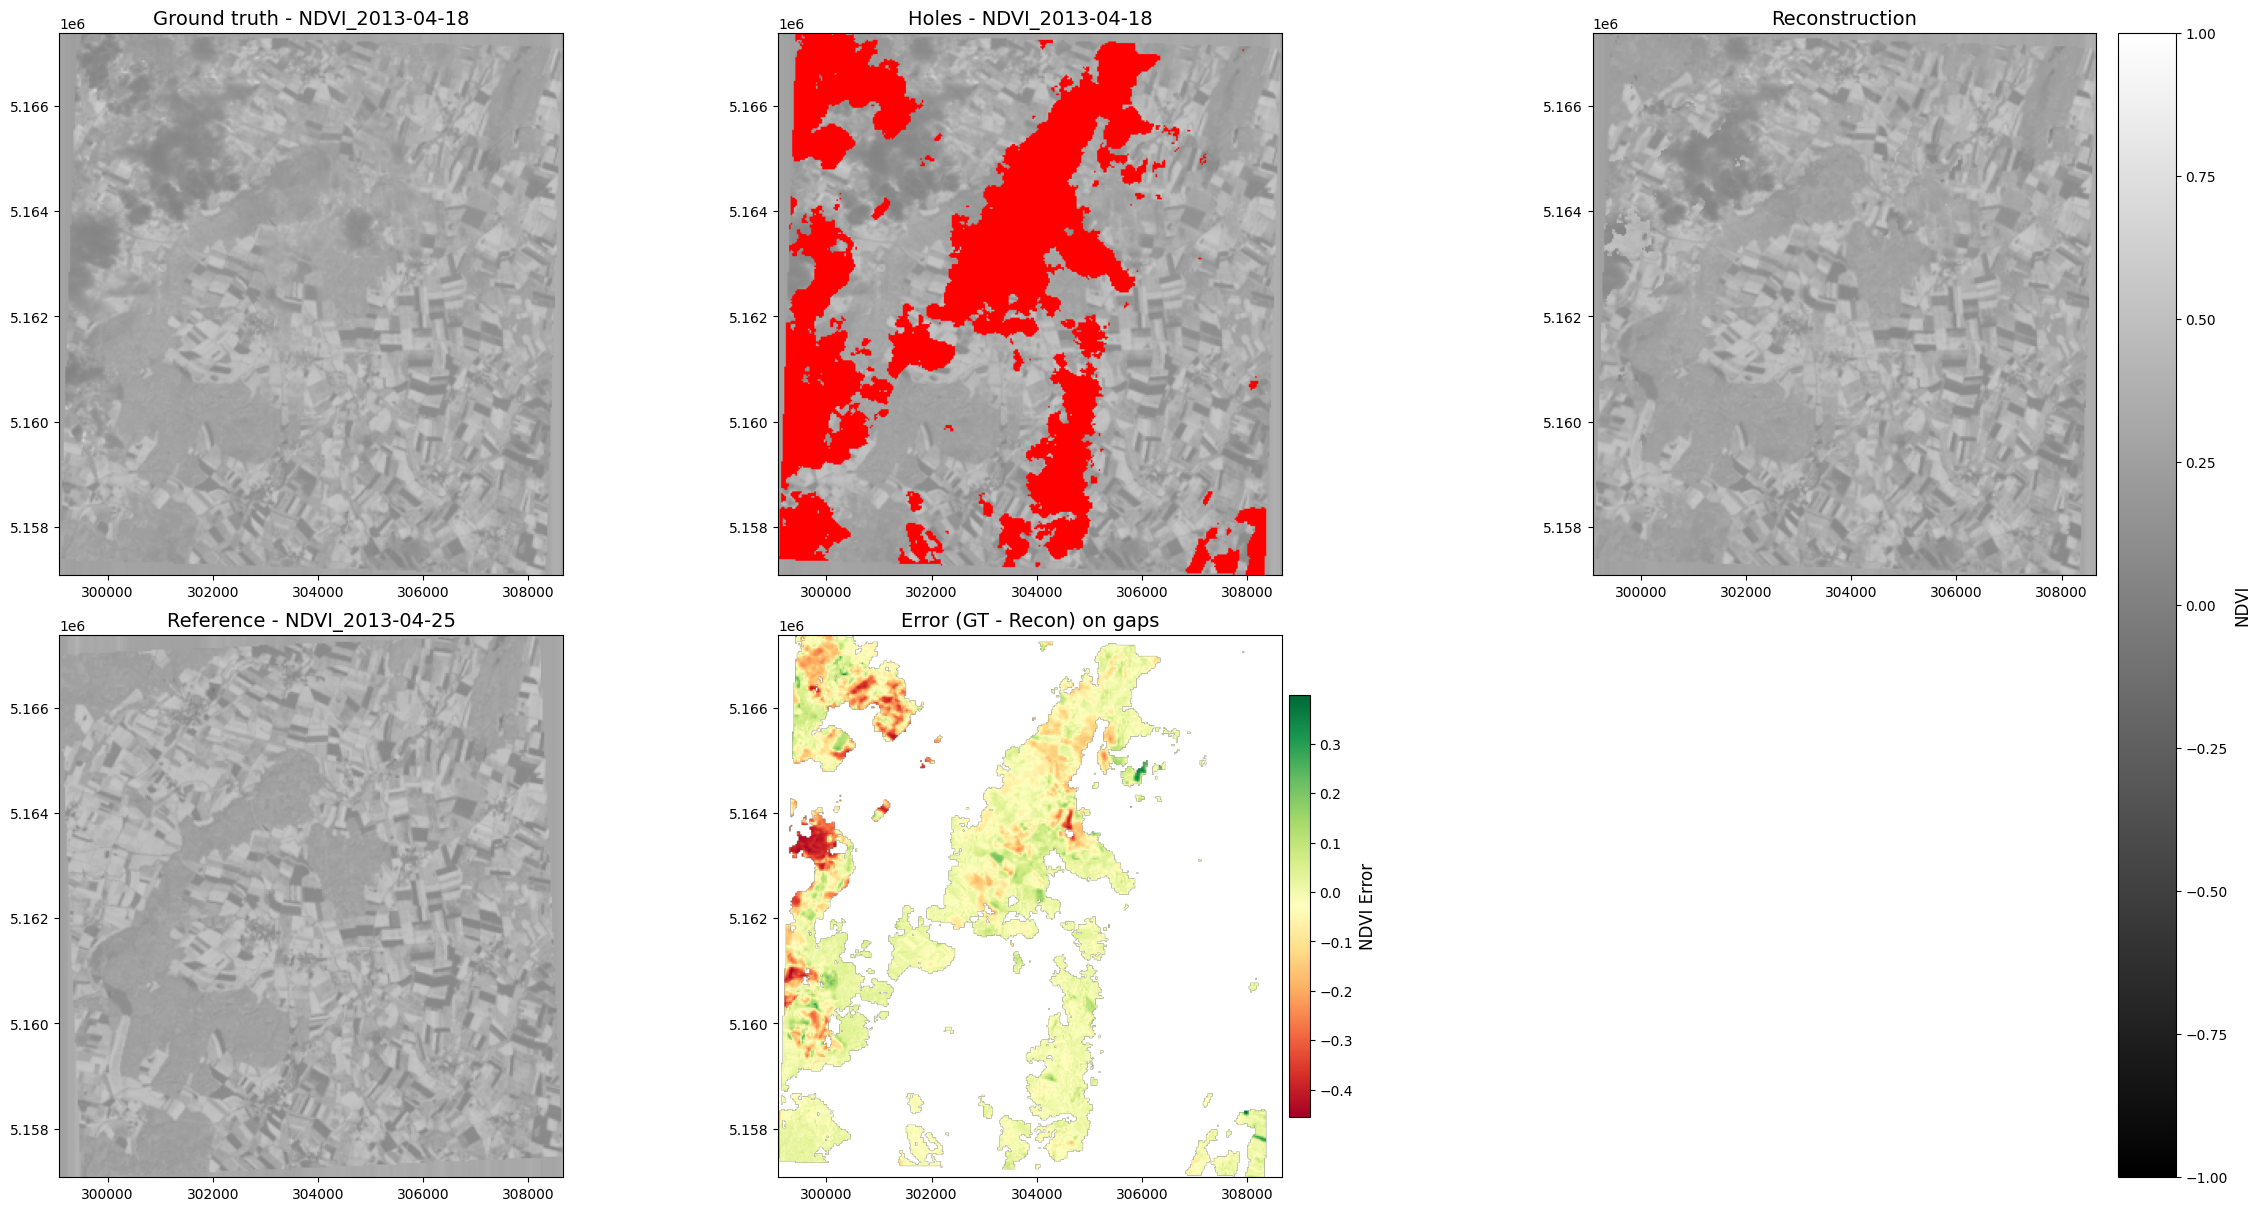

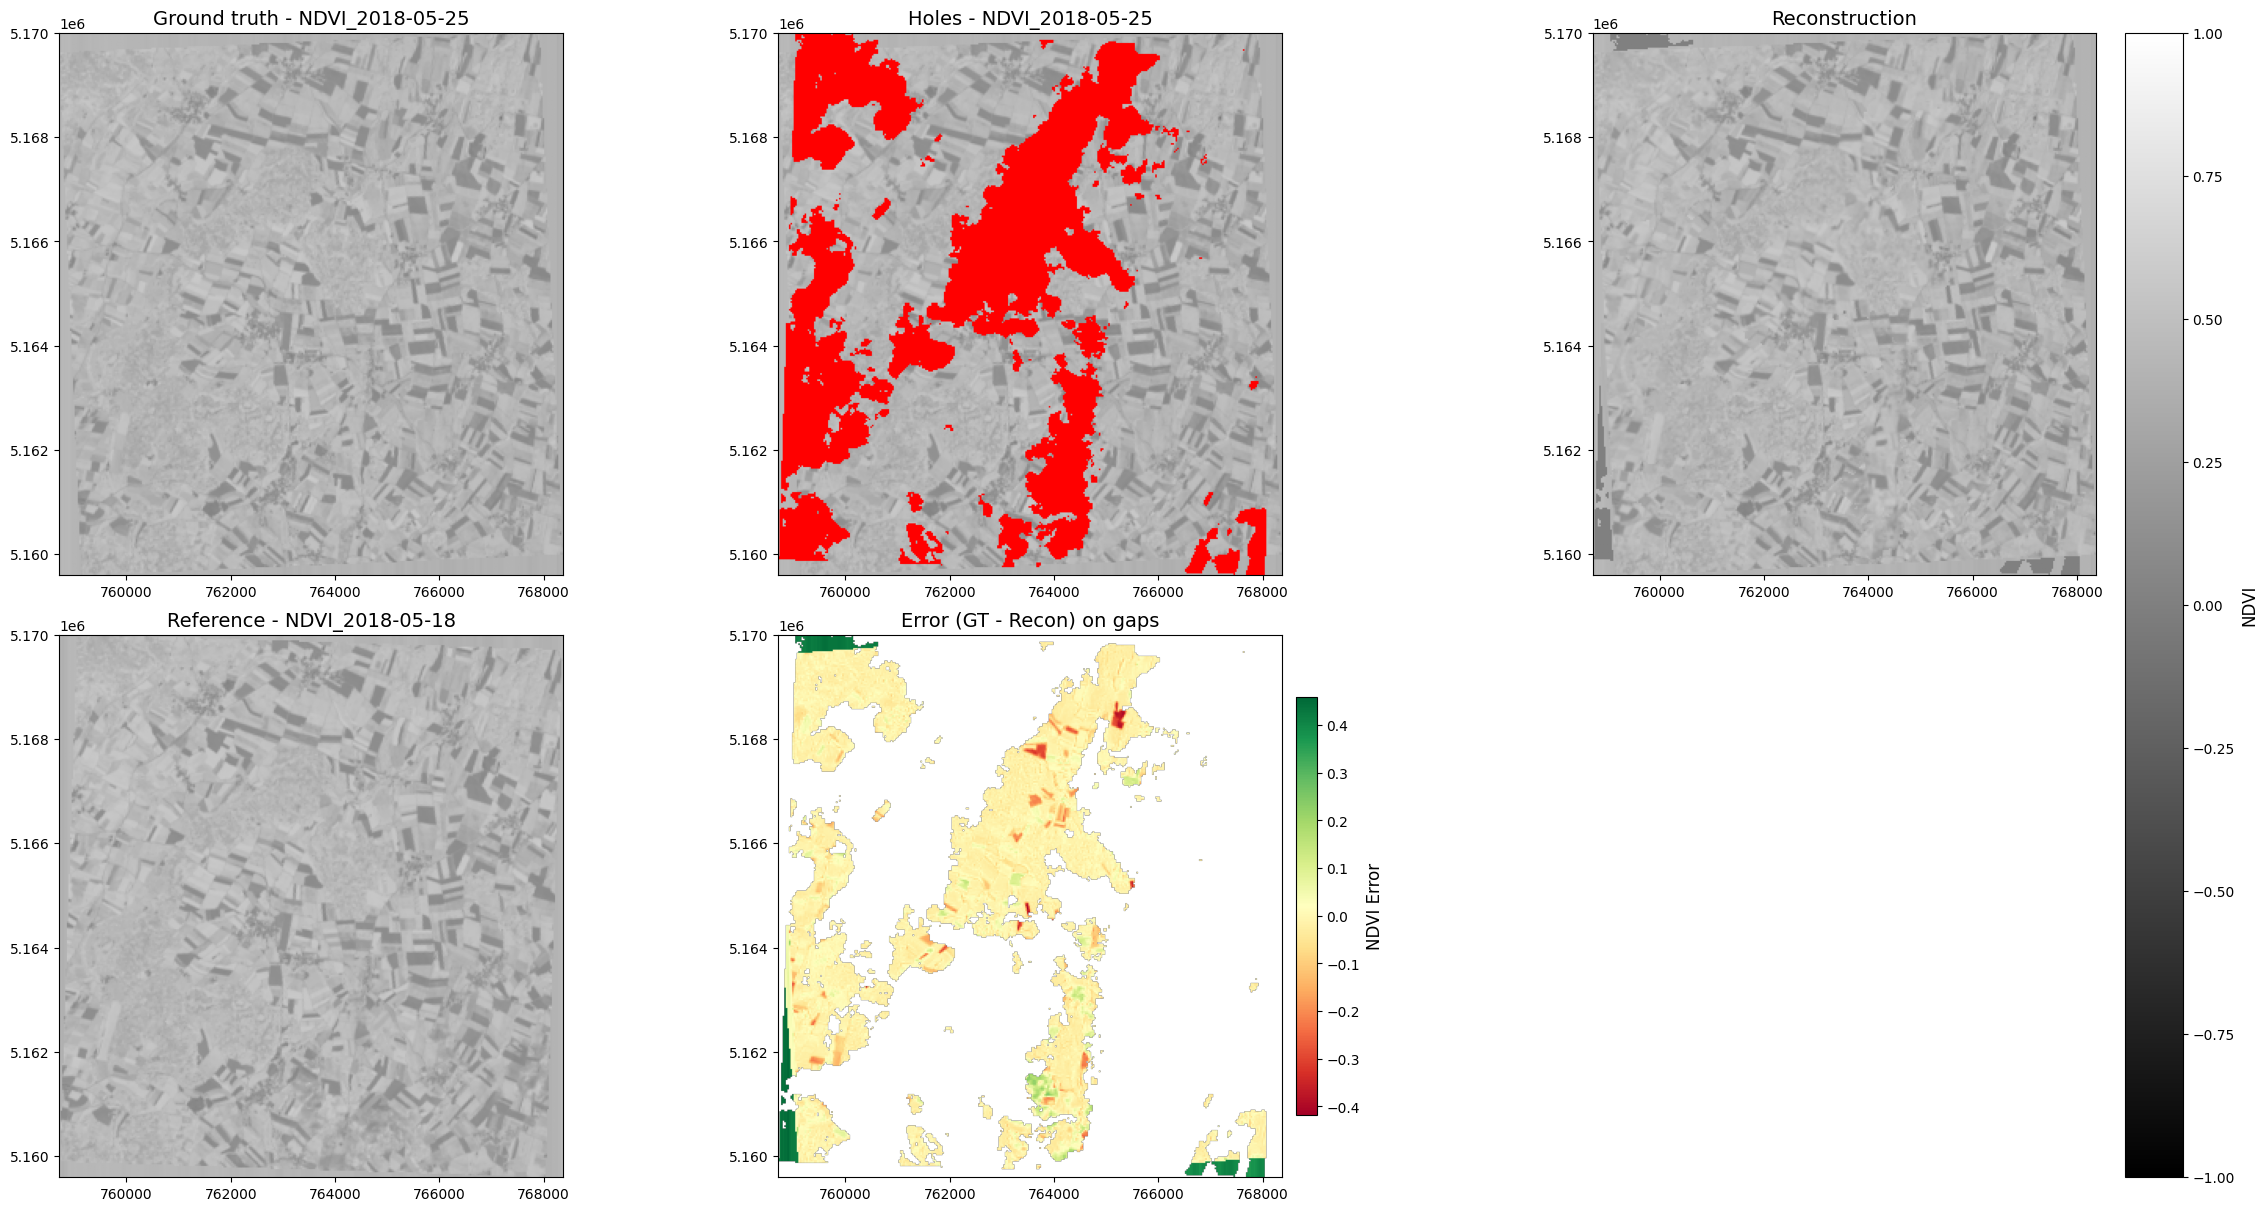

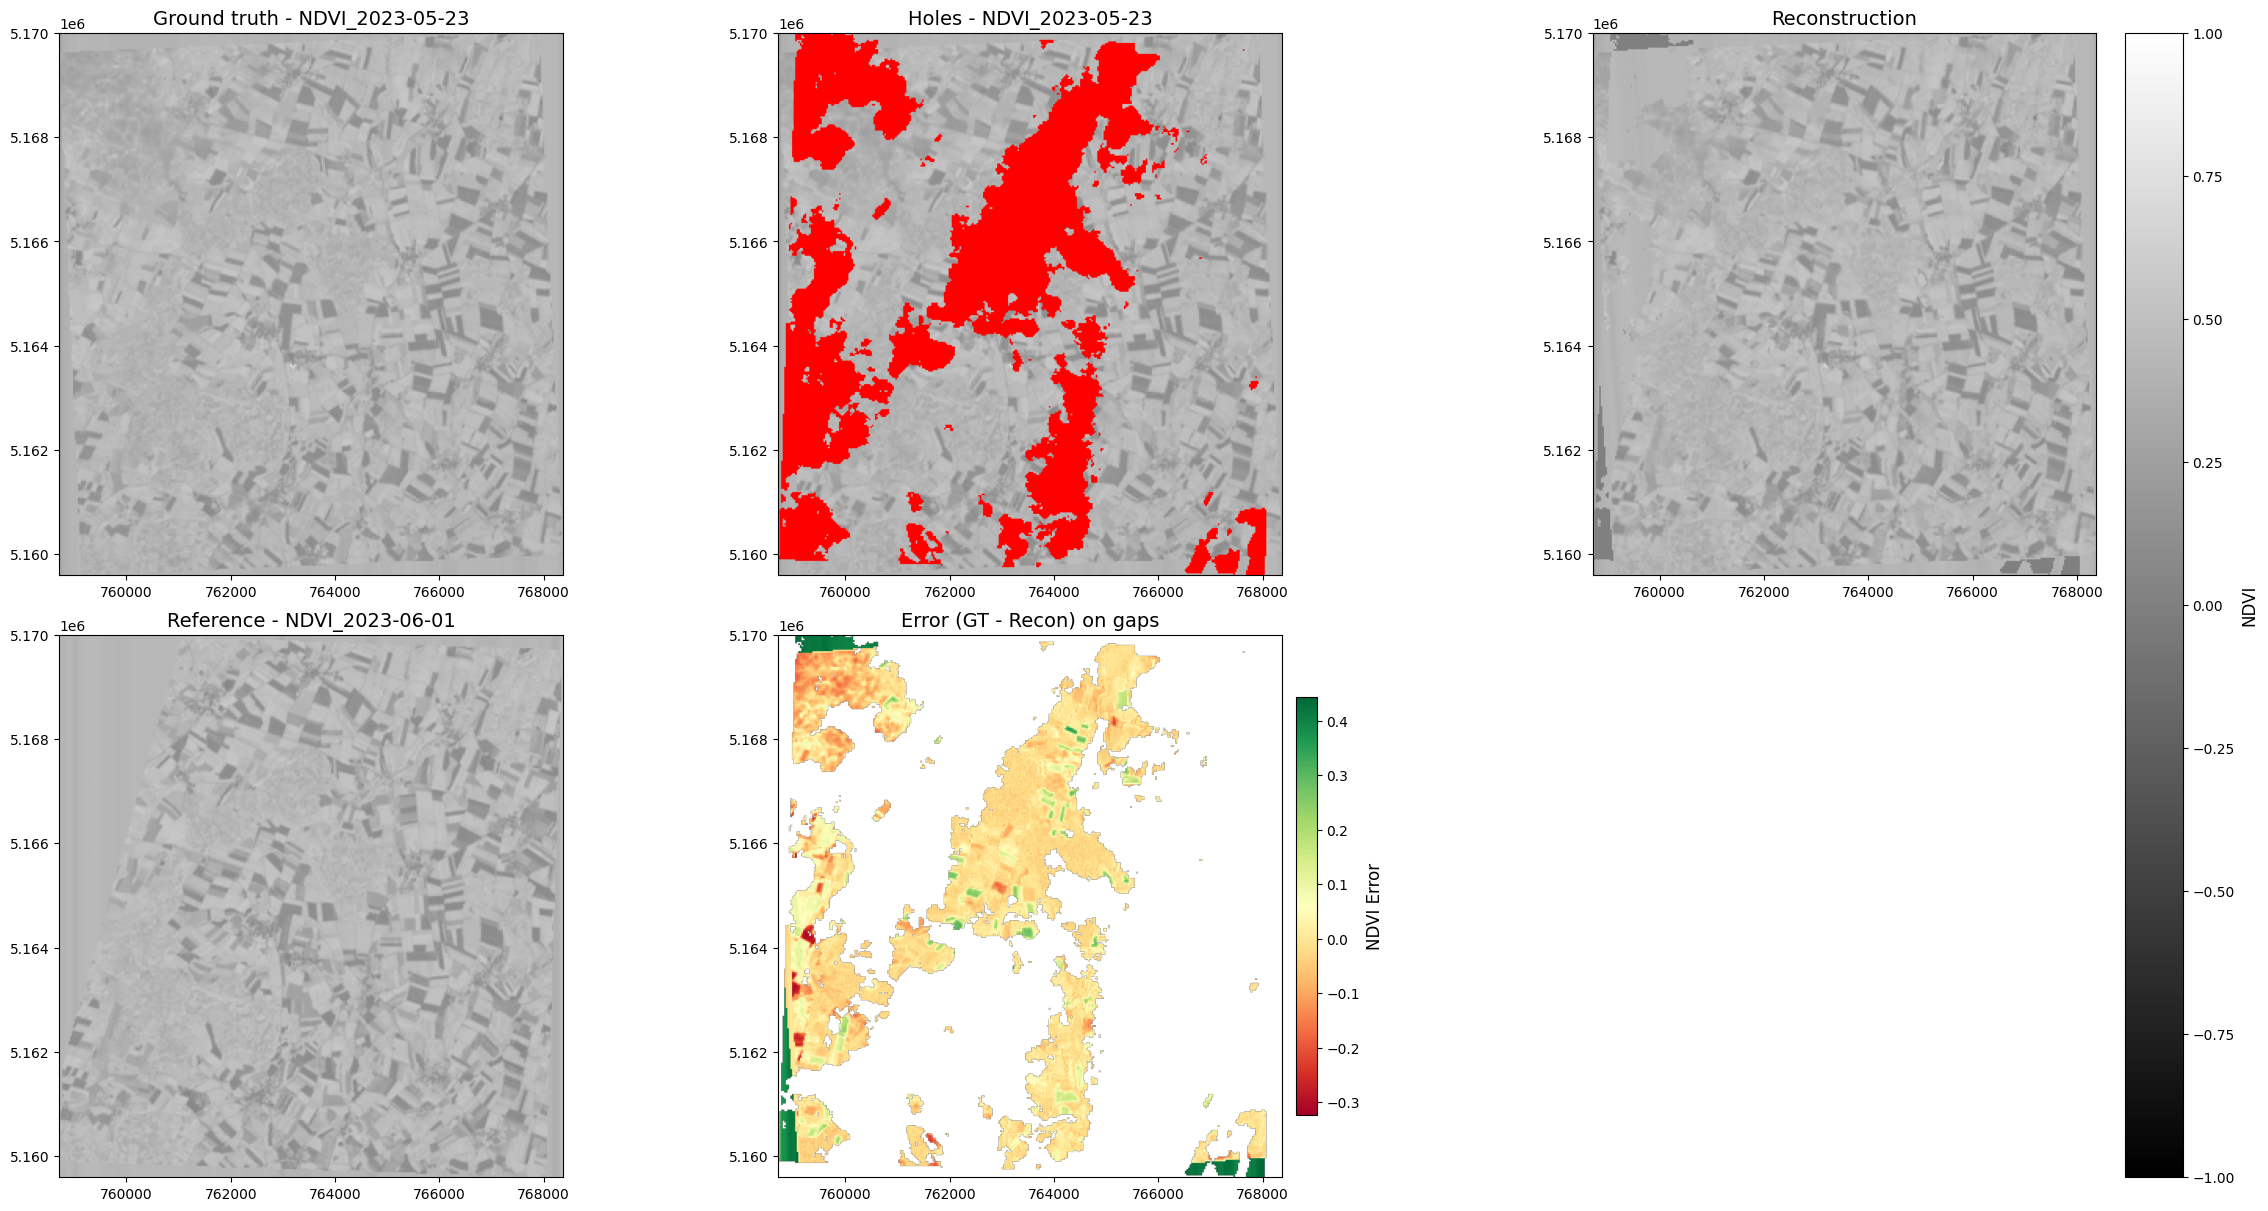

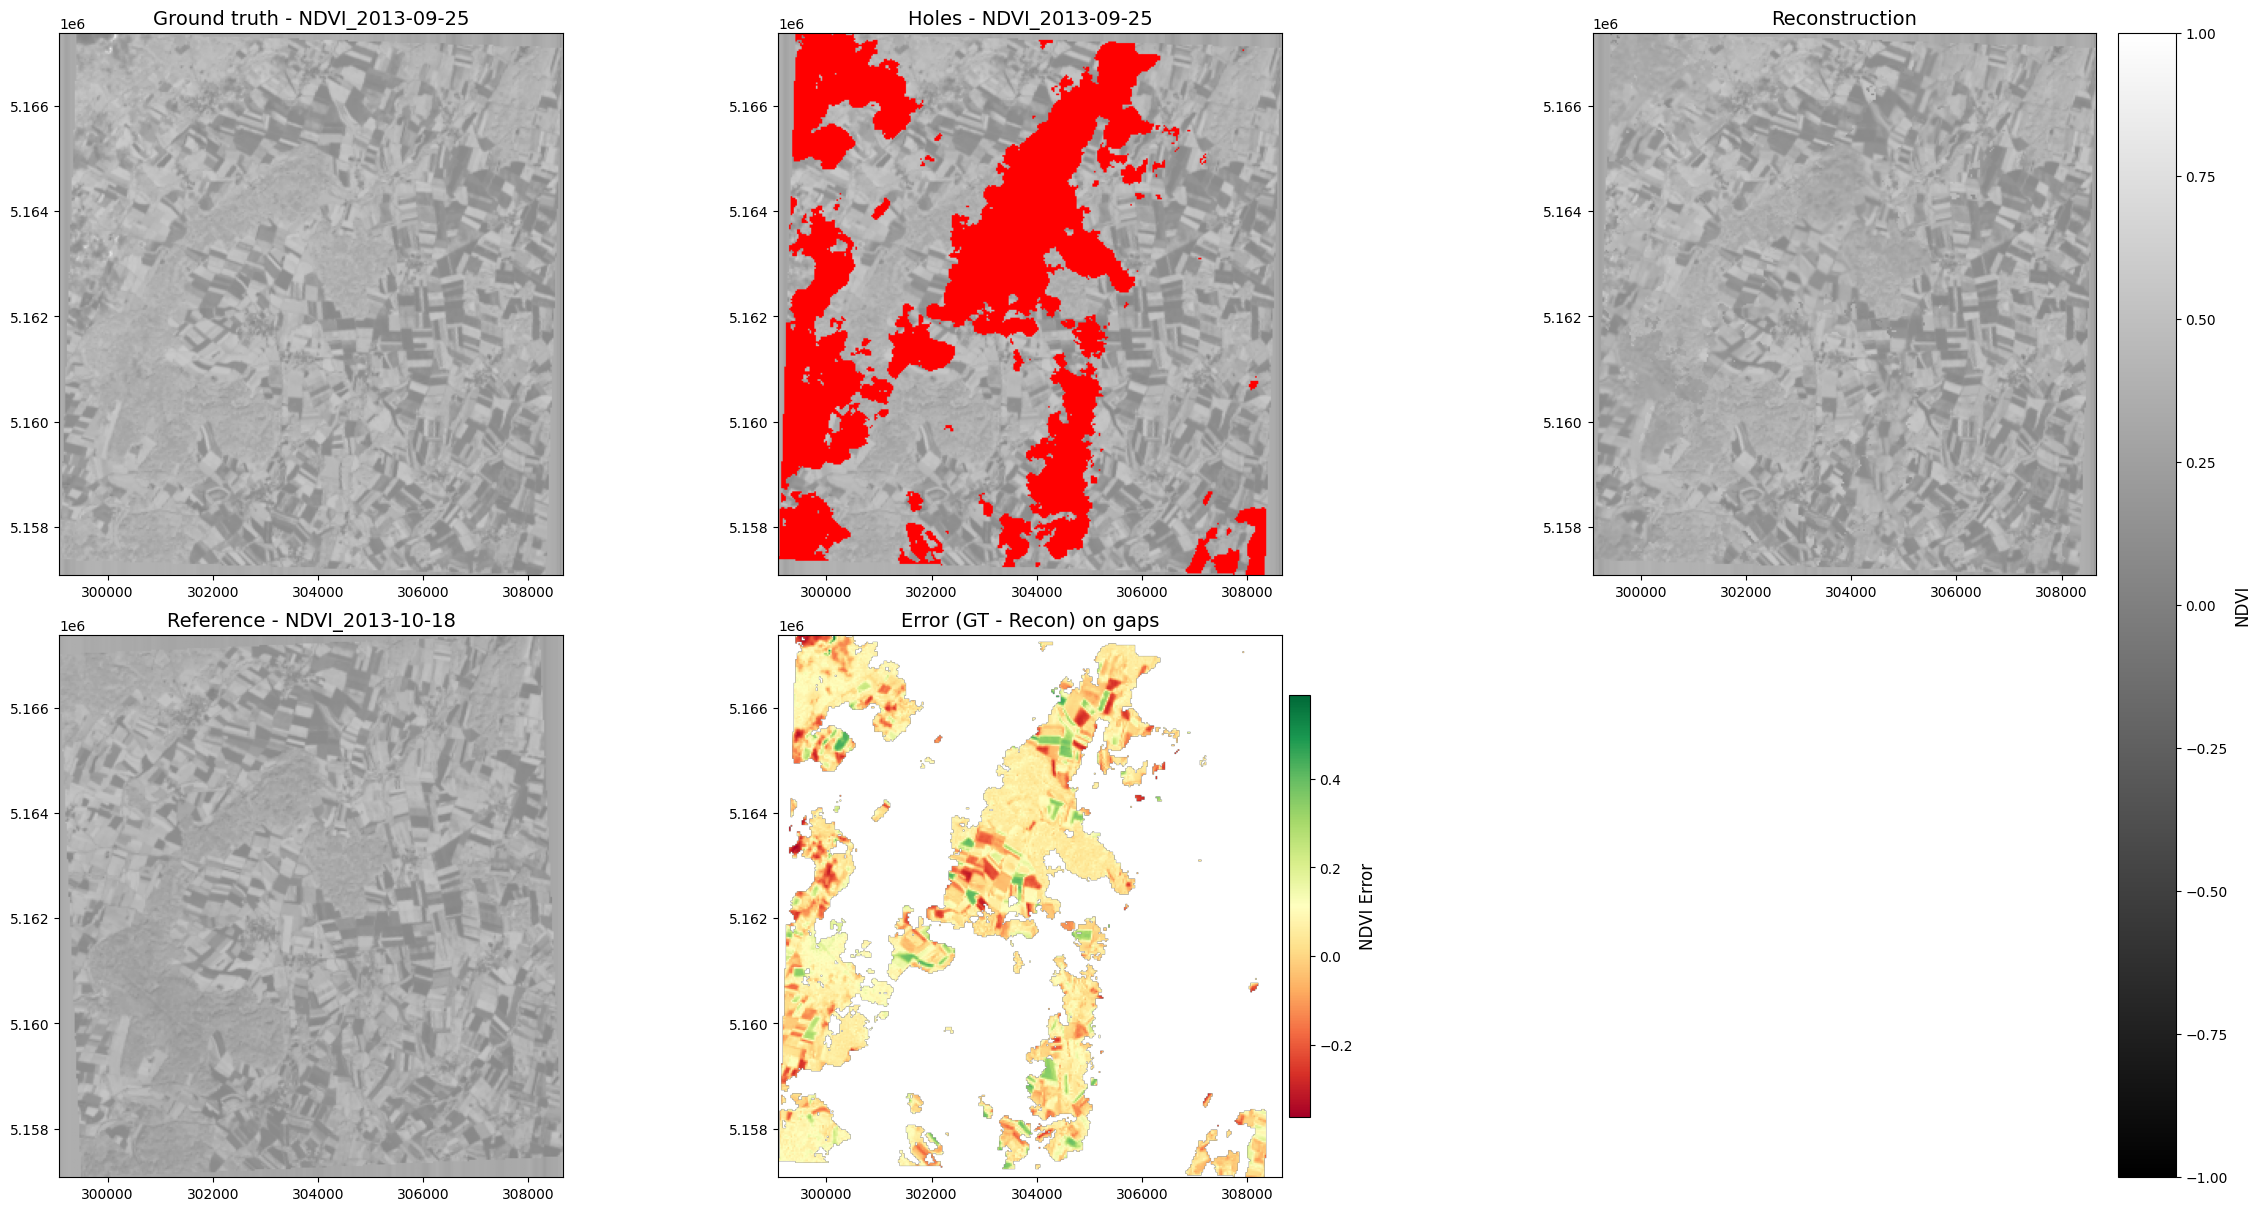

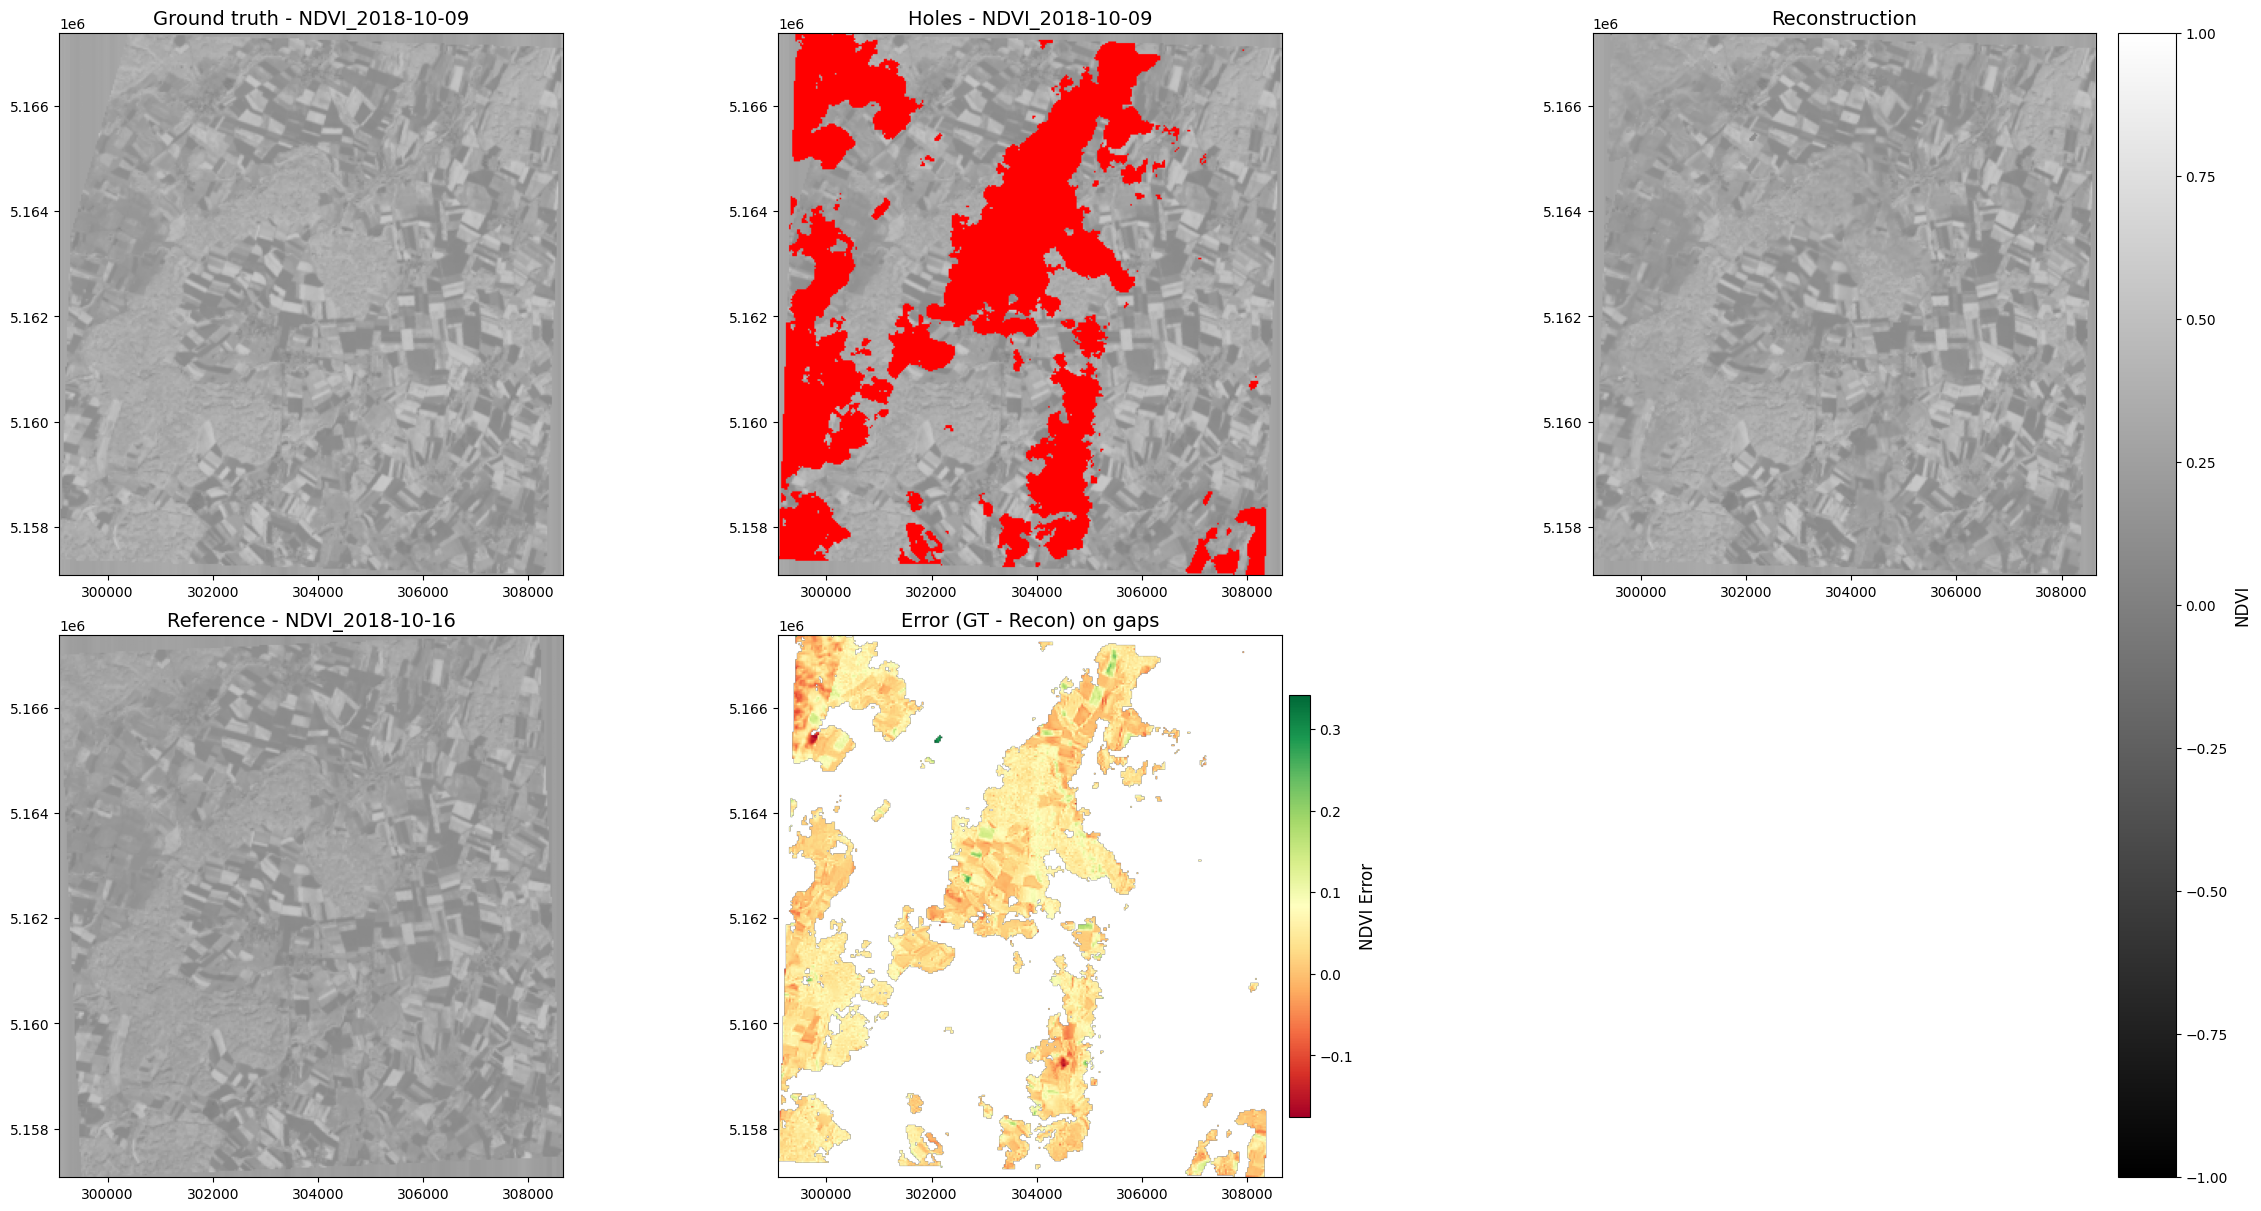

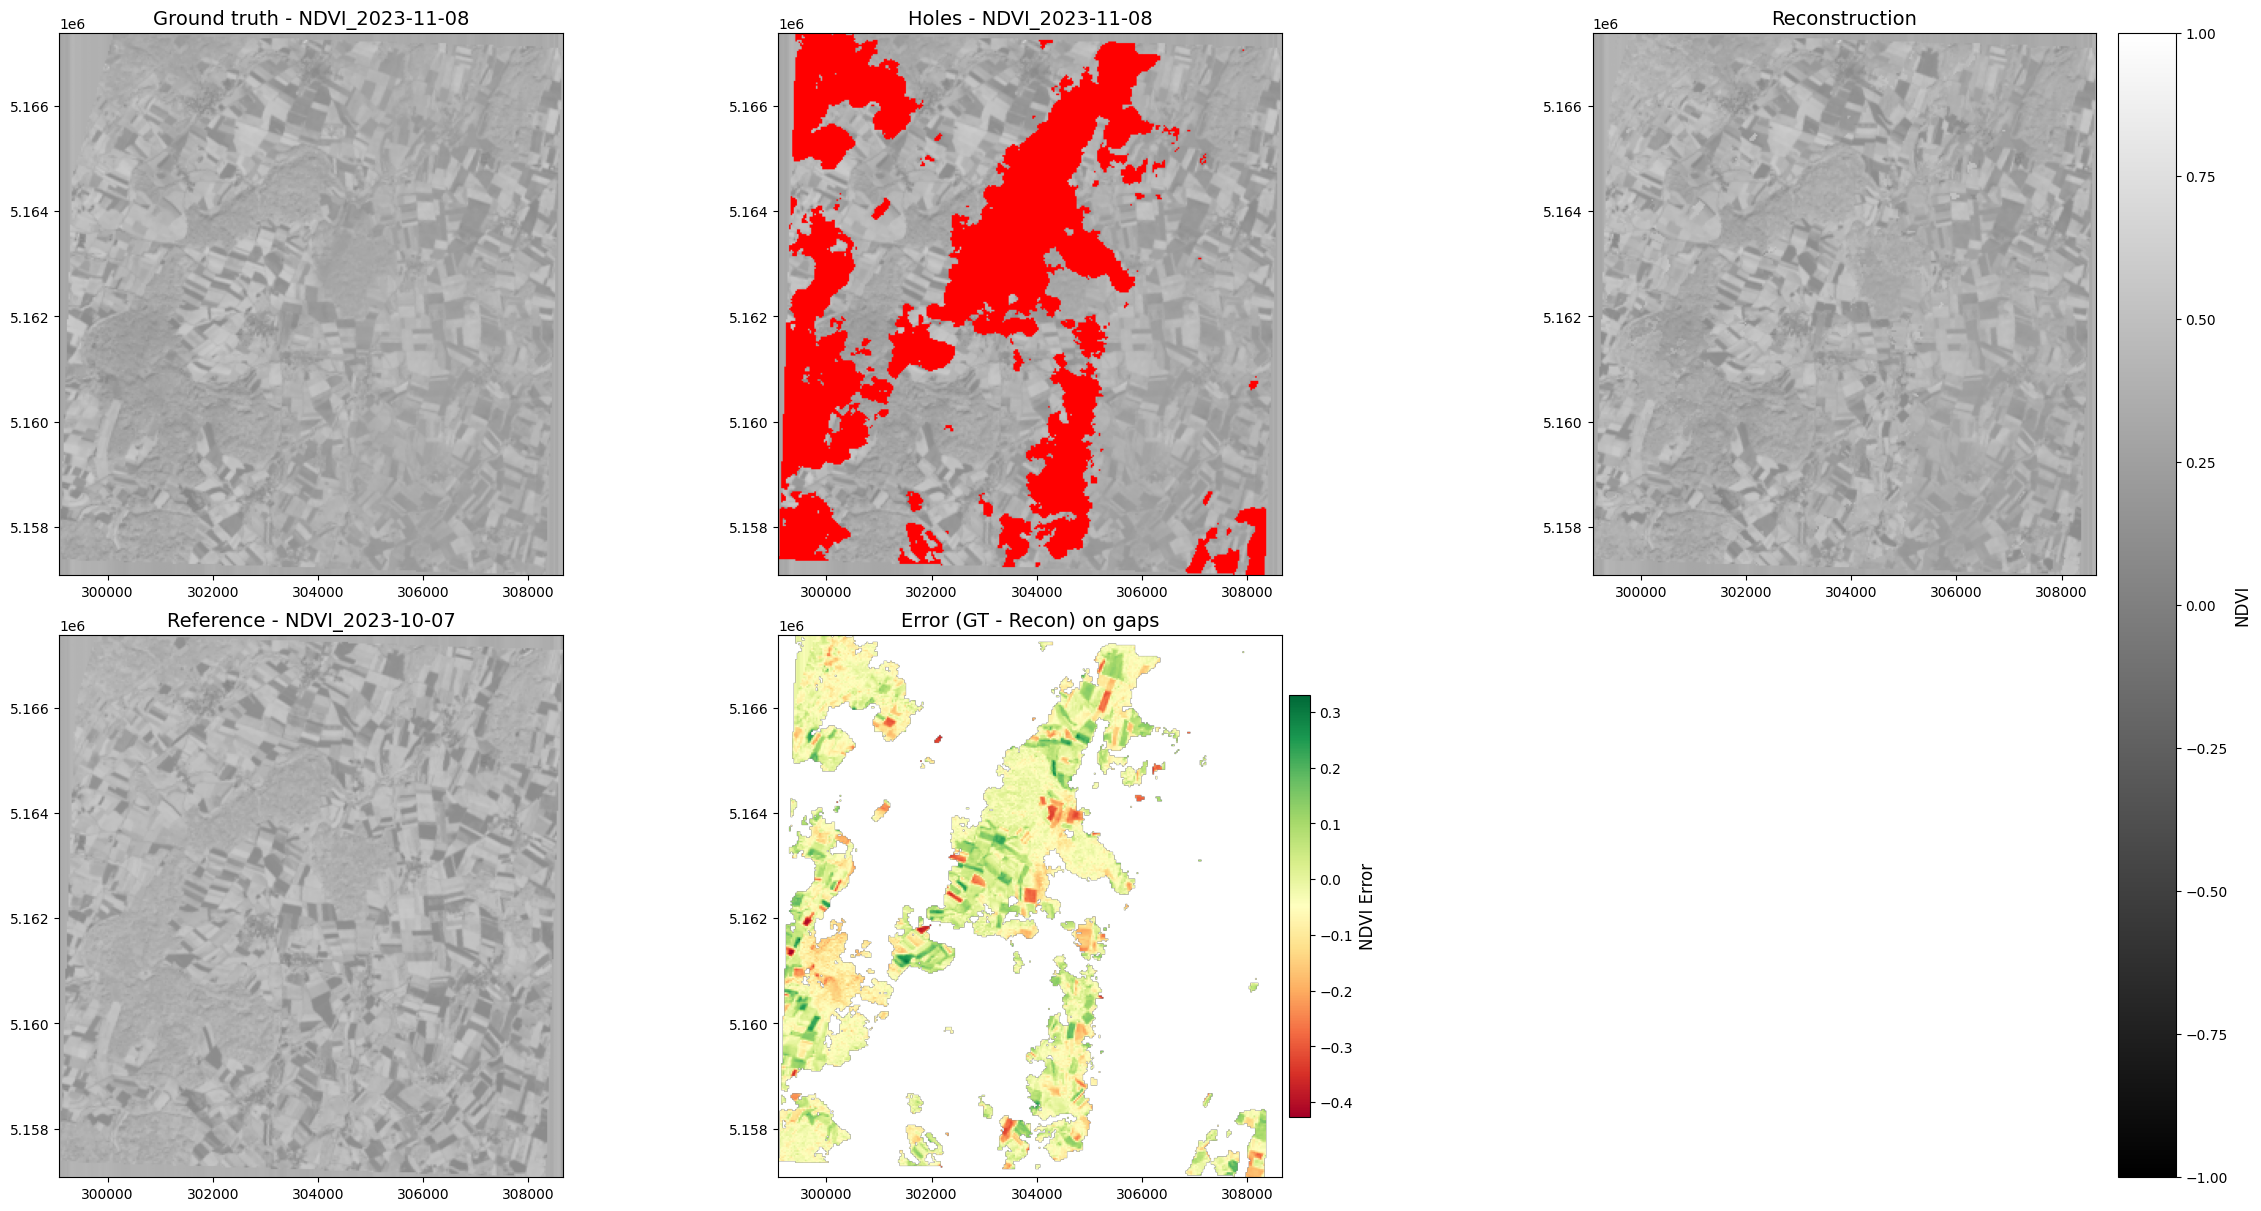

In [33]:
for date in dates_to_plot:
    fname = f"NDVI_{date}.tif"
    fname_baseline = f"NDVI_{date}_baseline.tif"

    gt_path = os.path.join(path_full, fname)
    target_path = os.path.join(path_with_holes, fname)
    recon_path = os.path.join(path_baseline, fname_baseline)
    ref_path = mapping_dict[date]

    with rasterio.open(gt_path) as src:
        gt_img = src.read(1).astype("float32")
    with rasterio.open(target_path) as src:
        target_img = src.read(1).astype("float32")
    with rasterio.open(recon_path) as src:
        recon_img = src.read(1).astype("float32")
    with rasterio.open(ref_path) as src:
        ref_img = src.read(1).astype("float32")

    gap_mask = np.isnan(target_img) | (target_img == -9999)

    visu_5(gt_img, target_img, recon_img, ref_img,
           gap_mask, gt_path, target_path, ref_path)
